## Experiment 1



In [5]:
import os
from dotenv import load_dotenv

# Load .env file
load_dotenv()

OPENAI_API_KEY = os.environ.get("OPENAI_API_KEY")


In [6]:
from datasets import load_dataset

ds = load_dataset("HuggingFaceM4/ChartQA")

/Users/armintalaie/miniconda3/envs/nlpviz/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
train_ds = ds["train"]
cols = train_ds.column_names
print(cols)

['image', 'query', 'label', 'human_or_machine']


In [8]:
from datasets import Image
train_ds = train_ds.cast_column("image", Image(decode=False))

# Then try to look at the raw data
first_item = train_ds[0]
# Print everything except the image data
print({k: v for k, v in first_item.items() if k != 'image'})

# Let's also check the type of the image data
print("Image data type:", type(first_item['image']))

{'query': 'Is the value of Favorable 38 in 2015?', 'label': ['Yes'], 'human_or_machine': 0}
Image data type: <class 'dict'>


Is the value of Favorable 38 in 2015?
['Yes']


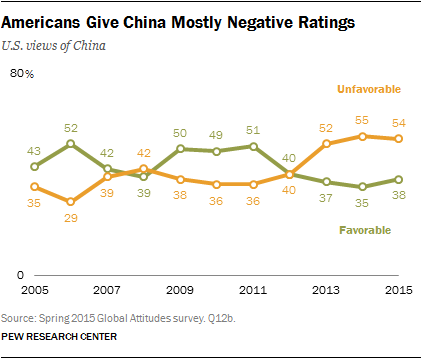

In [18]:
from PIL import Image
import io

img_data = train_ds[0]['image']['bytes']
img = Image.open(io.BytesIO(img_data))
print(train_ds[0]['query'])
print(train_ds[0]['label'])
display(img)  

In [42]:
import base64
from PIL import Image, ImageEnhance
import io
import numpy as np
from tabulate import tabulate

def create_image_variations(img_bytes):
    # Convert bytes to PIL Image
    img = Image.open(io.BytesIO(img_bytes))
    variations = {}
    
    # Black and White
    bw = img.convert('L')
    
    # Size manipulation
    width, height = img.size
    # Convert float values to integers for resize
    v_stretched = img.resize((width, int(height * 2)))
    h_stretched = img.resize((int(width * 2), height))
    h_squeezed = img.resize((int(width * 0.5), height))
    v_squeezed = img.resize((width, int(height * 0.5)))
    downscaled = img.resize((width // 2, height // 2))
    upscaled = img.resize((width * 2, height * 2))
    
    # Color manipulation
    converter = ImageEnhance.Color(img)
    # Saturation
    sat_increased = converter.enhance(1.8)
    sat_super_increased = converter.enhance(3)
    sat_decreased = converter.enhance(0.3)
    sat_super_decreased = converter.enhance(0.1)
    
    # Brightness
    brightness = ImageEnhance.Brightness(img)
    bright_increased = brightness.enhance(1.8)
    bright_super_increased = brightness.enhance(3)
    bright_decreased = brightness.enhance(0.3)
    bright_super_decreased = brightness.enhance(0.1)
    
    # Contrast
    contrast = ImageEnhance.Contrast(img)
    contrast_increased = contrast.enhance(1.8)
    contrast_super_increased = contrast.enhance(3)
    contrast_decreased = contrast.enhance(0.3)
    contrast_super_decreased = contrast.enhance(0.1)
    
    # Sharpness
    sharpness = ImageEnhance.Sharpness(img)
    sharpness_increased = sharpness.enhance(1.8)
    sharpness_super_increased = sharpness.enhance(3)
    sharpness_decreased = sharpness.enhance(0.3)
    sharpness_super_decreased = sharpness.enhance(0.1)


    # super sharp and super saturated
    sharpness = ImageEnhance.Sharpness(img)
    super_sharp = sharpness.enhance(3.0)  # First make it super sharp
    
    color = ImageEnhance.Color(super_sharp)
    super_sharp_and_saturated = color.enhance(3.0)  # Then make it super saturated
    
    # invert
    from PIL import ImageOps
    inverted = ImageOps.invert(img)
    
    variations = {
        "Baseline": img,
        "Black and White": bw,
        "Vertically Stretched": v_stretched,
        "Horizontally Stretched": h_stretched,
        "Squeezed Vertically": v_squeezed,
        "Squeezed Horizontally": h_squeezed,
        "Downscaled": downscaled,
        "Upscaled": upscaled,
        "Increased Saturation": sat_increased,
        "Super Increased Saturation": sat_super_increased,
        "Decreased Saturation": sat_decreased,
        "Super Decreased Saturation": sat_super_decreased,
        "Increased Brightness": bright_increased,
        "Super Increased Brightness": bright_super_increased,
        "Decreased Brightness": bright_decreased,
        "Super Decreased Brightness": bright_super_decreased,
        "Increased Contrast": contrast_increased,
        "Super Increased Contrast": contrast_super_increased,
        "Decreased Contrast": contrast_decreased,
        "Super Decreased Contrast": contrast_super_decreased,
        "Increased Sharpness": sharpness_increased,
        "Super Increased Sharpness": sharpness_super_increased,
        "Decreased Sharpness": sharpness_decreased,
        "Super Decreased Sharpness": sharpness_super_decreased,
        "Inverted": inverted,
        "Super Sharp and Super Saturated": super_sharp_and_saturated
    }
    
    return variations

def image_to_base64(pil_image):
    buffered = io.BytesIO()
    pil_image.save(buffered, format="PNG")
    return base64.b64encode(buffered.getvalue()).decode('utf-8')



In [43]:
def analyze_image(client, base64_image, query, desc, sample_num, true_label):
    try:
        completion = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {
                    "role": "user",
                    "content": [
                        {
                            "type": "text",
                            "text": f"Be concise. {query}"
                        },
                        {
                            "type": "image_url",
                            "image_url": {
                                "url": f"data:image/png;base64,{base64_image}"
                            }
                        }
                    ]
                }
            ],
            max_tokens=300
        )

        return [f"Sample {sample_num}", desc, query, true_label, completion.choices[0].message.content]
    except Exception as e:
        return [f"Sample {sample_num}", desc, query, true_label, f"Error: {str(e)}"]



In [44]:
def evaluate_response(client, response, true_label):
    prompt = f"""
    Compare the model's response '{response}' with the true label '{true_label}'.
    If the response is correct, return exactly '1.0'.
    If incorrect, analyze how wrong it is and return a score from 0.0 to 0.9, where:
    - 0.0-0.3: completely wrong or contradictory
    - 0.4-0.6: partially correct but missing key elements
    - 0.7-0.9: mostly correct with minor discrepancies
    Return ONLY the numeric score without any explanation.
    """
    
    try:
        completion = client.chat.completions.create(
            model="gpt-4",  # Using GPT-4 for better evaluation
            messages=[
                {
                    "role": "user",
                    "content": prompt
                }
            ],
            max_tokens=10
        )
        score = float(completion.choices[0].message.content.strip())
        return score
    except Exception as e:
        return f"Error: {str(e)}"

def process_samples(train_ds, client, start_idx=10, end_idx=20):
    results = []
    all_variations = {}
    
    for i in range(start_idx, end_idx):
        print(f"Processing sample {i+1}...")  # Progress indicator
        sample = train_ds[i]
        variations = create_image_variations(sample['image']['bytes'])
        all_variations[f"Sample {i+1}"] = variations
        query = sample['query']
        true_label = sample['label'][0]
        
        for desc, img in variations.items():
            print(f"  Processing variation: {desc}")  # Progress indicator
            base64_img = image_to_base64(img)
            result = analyze_image(client, base64_img, query, desc, i+1, true_label)
            
            # Get the model's response from the result
            model_response = result[4]  # Assuming this is where the response is
            
            # Evaluate the response
            correctness_score = evaluate_response(client, model_response, true_label)
            
            # Append the score to the result
            result.append(correctness_score)
            results.append(result)
            
    return results, all_variations



In [45]:
def display_results_in_notebook(results, variations_dict):
    html = """
    <style>
        table { border-collapse: collapse; width: 100%; margin-bottom: 20px; }
        th, td { border: 1px solid black; padding: 8px; text-align: left; }
        img { max-width: 200px; height: auto; }
        .sample-section { margin-bottom: 30px; }
        .score-high { background-color: #90EE90; }
        .score-med { background-color: #FFE4B5; }
        .score-low { background-color: #FFB6C1; }
    </style>
    """
    
    # Group results by sample number
    sample_groups = {}
    for row in results:
        sample_num = row[0]
        if sample_num not in sample_groups:
            sample_groups[sample_num] = []
        sample_groups[sample_num].append(row)
    
    # Create section for each sample
    for sample_num, rows in sample_groups.items():
        html += f"<div class='sample-section'><h2>{sample_num}</h2>"
        html += "<table>"
        html += "<tr><th>Image Type</th><th>Image</th><th>Query</th><th>True Label</th><th>Model Response</th><th>Correctness Score</th></tr>"
        
        for row in results:
            _, desc, query, true_label, response, score = row
            
            # Get the corresponding image
            img = variations_dict.get(desc)
            if img:
                img_base64 = image_to_base64(img)
                img_html = f"<img src='data:image/png;base64,{img_base64}'>"
            else:
                img_html = "Image not available"
            
            # Determine score class
            if isinstance(score, (int, float)):
                if score >= 0.7:
                    score_class = f"{score} score-high"
                elif score >= 0.4:
                    score_class = f"{score} score-med"
                else:
                    score_class = f"{score} score-low"
            else:
                score_class = ""
            
            html += f"""
            <tr>
                <td>{desc}</td>
                <td>{img_html}</td>
                <td>{query}</td>
                <td>{true_label}</td>
                <td>{response}</td>
                <td class="{score_class}">{score}</td>
            </tr>
            """
        
        html += "</table></div>"
    
    return HTML(html)


In [50]:
def main():
    results, all_variations = process_samples(train_ds, client, start_idx=10, end_idx=100)
    
    # Display in notebook
    # display(display_results_in_notebook(results, all_variations))
    
    # Save to CSV
    df = pd.DataFrame(results, columns=['Sample #', 'Image Type', 'Query', 'True Label', 'Model Response', 'Correctness Score'])
    df.to_csv('image_analysis_results.csv', index=False)
    
    # Print some statistics
    # df['Correctness Score'] = pd.to_numeric(df['Correctness Score'], errors='coerce')
    # print("\nAnalysis Summary:")
    # print(f"Average score: {df['Correctness Score'].mean():.2f}")
    # print("\nScores by image type:")
    # print(df.groupby('Image Type')['Correctness Score'].mean().sort_values(ascending=False))

# Execute
main()

Processing sample 11...
  Processing variation: Baseline
  Processing variation: Black and White
  Processing variation: Vertically Stretched
  Processing variation: Horizontally Stretched
  Processing variation: Squeezed Vertically
  Processing variation: Squeezed Horizontally
  Processing variation: Downscaled
  Processing variation: Upscaled
  Processing variation: Increased Saturation
  Processing variation: Super Increased Saturation
  Processing variation: Decreased Saturation
  Processing variation: Super Decreased Saturation
  Processing variation: Increased Brightness
  Processing variation: Super Increased Brightness
  Processing variation: Decreased Brightness
  Processing variation: Super Decreased Brightness
  Processing variation: Increased Contrast
  Processing variation: Super Increased Contrast
  Processing variation: Decreased Contrast
  Processing variation: Super Decreased Contrast
  Processing variation: Increased Sharpness
  Processing variation: Super Increased S

Statistics by Image Type:
                                Correctness Score                            \
                                            count   mean median    std  min   
Image Type                                                                    
Upscaled                                       90  0.717   1.00  0.415  0.0   
Increased Saturation                           90  0.699   1.00  0.432  0.0   
Super Increased Sharpness                      90  0.682   1.00  0.437  0.0   
Vertically Stretched                           90  0.673   1.00  0.435  0.0   
Squeezed Horizontally                          90  0.666   1.00  0.441  0.0   
Super Increased Saturation                     90  0.663   0.90  0.430  0.0   
Horizontally Stretched                         90  0.661   1.00  0.444  0.0   
Decreased Sharpness                            90  0.658   0.90  0.428  0.0   
Super Decreased Sharpness                      90  0.650   1.00  0.438  0.0   
Super Decreased Brightness

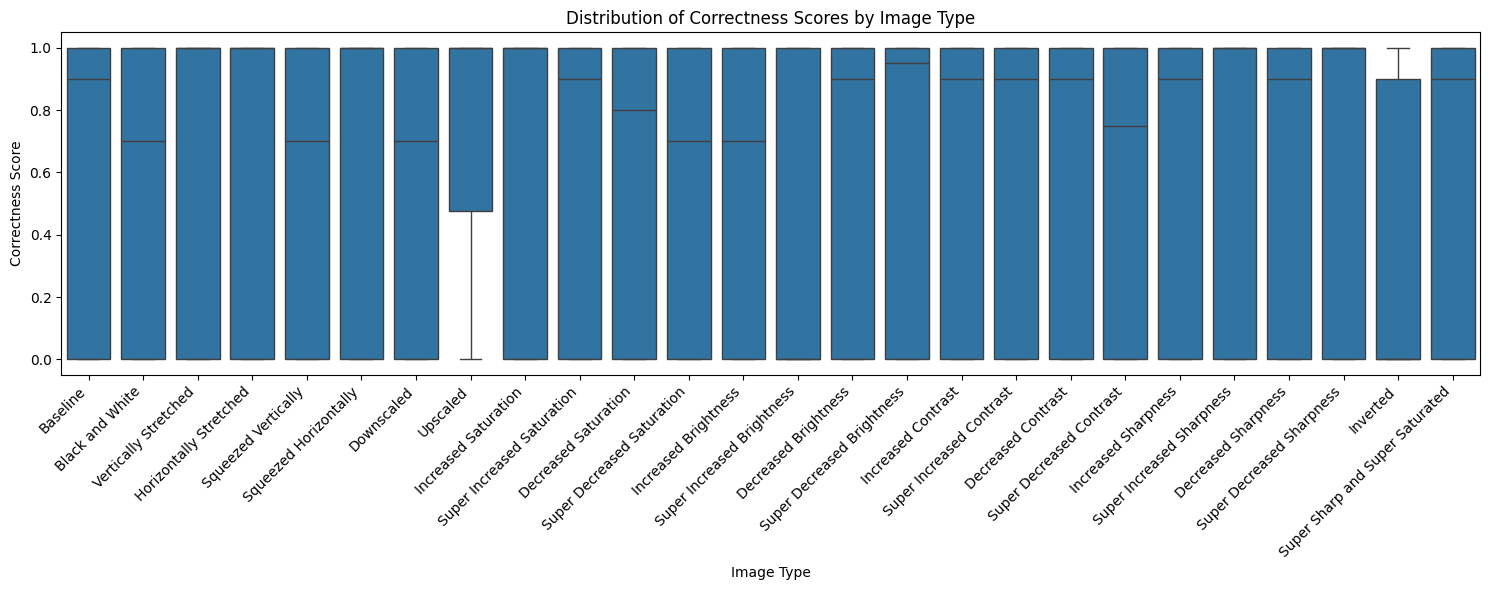

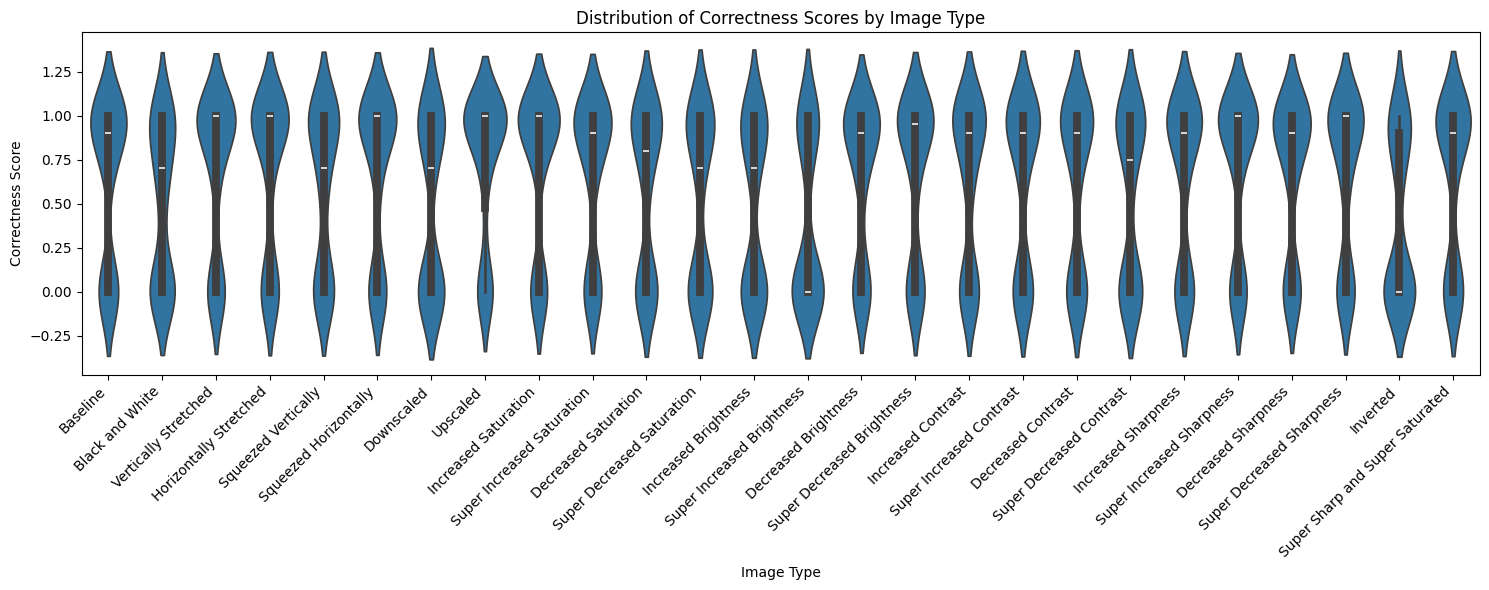


Top 5 Most Effective Transformations:
                          Correctness Score                               
                                      count   mean median    std  min  max
Image Type                                                                
Upscaled                                 90  0.717    1.0  0.415  0.0  1.0
Increased Saturation                     90  0.699    1.0  0.432  0.0  1.0
Super Increased Sharpness                90  0.682    1.0  0.437  0.0  1.0
Vertically Stretched                     90  0.673    1.0  0.435  0.0  1.0
Squeezed Horizontally                    90  0.666    1.0  0.441  0.0  1.0

Bottom 5 Least Effective Transformations:
                           Correctness Score                               
                                       count   mean median    std  min  max
Image Type                                                                 
Black and White                           90  0.506    0.7  0.442  0.0  1.0
Downscaled    

In [52]:
import pandas as pd

# Load the CSV
df = pd.read_csv('image_analysis_results.csv')

# Basic statistics grouped by Image Type
stats = df.groupby('Image Type').agg({
   'Correctness Score': ['count', 'mean', 'median', 'std', 'min', 'max']
}).round(3)

# Sort by mean score descending
stats = stats.sort_values(('Correctness Score', 'mean'), ascending=False)

print("Statistics by Image Type:")
print(stats)

# Optional: Visual representation
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 6))
sns.boxplot(data=df, x='Image Type', y='Correctness Score')
plt.xticks(rotation=45, ha='right')
plt.title('Distribution of Correctness Scores by Image Type')
plt.tight_layout()
plt.show()

# You might also want to see distribution of scores
plt.figure(figsize=(15, 6))
sns.violinplot(data=df, x='Image Type', y='Correctness Score')
plt.xticks(rotation=45, ha='right')
plt.title('Distribution of Correctness Scores by Image Type')
plt.tight_layout()
plt.show()

# Print top performing transformations
print("\nTop 5 Most Effective Transformations:")
print(stats.head())

print("\nBottom 5 Least Effective Transformations:")
print(stats.tail())


# save images to folder


In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load and process data
df = pd.read_csv('image_analysis_results.csv')

# Calculate statistics
stats = df.groupby('Image Type').agg({
    'Correctness Score': ['count', 'mean', 'median', 'std', 'min', 'max']
}).round(3)
stats = stats.sort_values(('Correctness Score', 'mean'), ascending=False)

# Save statistics to different formats
# Excel with formatted table
stats.to_excel('image_type_statistics.xlsx')

# CSV format
stats.to_csv('image_type_statistics.csv')

# HTML table
stats.to_html('image_type_statistics.html')

# Create and save visualizations
# Box plot
plt.figure(figsize=(15, 6))
sns.boxplot(data=df, x='Image Type', y='Correctness Score')
plt.xticks(rotation=45, ha='right')
plt.title('Distribution of Correctness Scores by Image Type')
plt.tight_layout()
plt.savefig('score_distribution_boxplot.png', dpi=300, bbox_inches='tight')
plt.close()

# Violin plot
plt.figure(figsize=(15, 6))
sns.violinplot(data=df, x='Image Type', y='Correctness Score')
plt.xticks(rotation=45, ha='right')
plt.title('Distribution of Correctness Scores by Image Type')
plt.tight_layout()
plt.savefig('score_distribution_violin.png', dpi=300, bbox_inches='tight')
plt.close()

# Bar plot of means with error bars
plt.figure(figsize=(15, 6))
means = df.groupby('Image Type')['Correctness Score'].mean().sort_values(ascending=False)
errors = df.groupby('Image Type')['Correctness Score'].std()
means.plot(kind='bar', yerr=errors, capsize=5)
plt.xticks(rotation=45, ha='right')
plt.title('Mean Correctness Scores by Image Type with Standard Deviation')
plt.tight_layout()
plt.savefig('mean_scores_bar.png', dpi=300, bbox_inches='tight')
plt.close()

# Create a more detailed report in HTML
html_content = f"""
<html>
<head>
    <style>
        body {{ font-family: Arial, sans-serif; margin: 20px; }}
        table {{ border-collapse: collapse; width: 100%; }}
        th, td {{ border: 1px solid #ddd; padding: 8px; text-align: left; }}
        th {{ background-color: #f2f2f2; }}
        img {{ max-width: 100%; height: auto; margin: 20px 0; }}
        .section {{ margin: 40px 0; }}
    </style>
</head>
<body>
    <h1>Image Transformation Analysis Report</h1>
    
    <div class="section">
        <h2>Statistical Summary</h2>
        {stats.to_html()}
    </div>
    
    <div class="section">
        <h2>Visualizations</h2>
        <h3>Box Plot Distribution</h3>
        <img src="score_distribution_boxplot.png" alt="Box Plot">
        
        <h3>Violin Plot Distribution</h3>
        <img src="score_distribution_violin.png" alt="Violin Plot">
        
        <h3>Mean Scores with Standard Deviation</h3>
        <img src="mean_scores_bar.png" alt="Mean Scores">
    </div>
</body>
</html>
"""

with open('analysis_report.html', 'w') as f:
    f.write(html_content)

print("Files saved:")
print("1. image_type_statistics.xlsx")
print("2. image_type_statistics.csv")
print("3. image_type_statistics.html")
print("4. score_distribution_boxplot.png")
print("5. score_distribution_violin.png")
print("6. mean_scores_bar.png")
print("7. analysis_report.html (complete report with tables and figures)")

Files saved:
1. image_type_statistics.xlsx
2. image_type_statistics.csv
3. image_type_statistics.html
4. score_distribution_boxplot.png
5. score_distribution_violin.png
6. mean_scores_bar.png
7. analysis_report.html (complete report with tables and figures)


In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV
df = pd.read_csv('image_analysis_results.csv')

# Group by Sample # and get majority response
sample_analysis = df.groupby('Sample #').agg({
   'Query': 'first',
   'True Label': 'first',
   'Model Response': lambda x: x.mode().iloc[0],
   'Correctness Score': ['mean', 'std', 'median']
}).round(3)

# Add count of different responses per sample
response_diversity = df.groupby('Sample #')['Model Response'].nunique()
sample_analysis['Unique_Responses'] = response_diversity

# Calculate agreement percentage
def calculate_agreement(group):
   most_common = group['Model Response'].mode().iloc[0]
   agreement = (group['Model Response'] == most_common).mean() * 100
   return agreement

agreement_scores = df.groupby('Sample #').apply(calculate_agreement)
sample_analysis['Agreement_Percentage'] = agreement_scores

# Sort by Sample number (assuming they're numeric, remove any "Sample " prefix)
sample_analysis = sample_analysis.sort_index()

print("Analysis by Sample:")
print(sample_analysis)

# Create visualizations

# 1. Agreement Percentage Bar Chart
plt.figure(figsize=(15, 5))
plt.bar(agreement_scores.index, agreement_scores.values)
plt.title('Agreement Percentage by Sample')
plt.xlabel('Sample Number')
plt.ylabel('Agreement Percentage')
plt.axhline(y=agreement_scores.mean(), color='r', linestyle='--', label=f'Mean Agreement: {agreement_scores.mean():.1f}%')
plt.legend()
plt.tight_layout()
plt.savefig('agreement_percentage.png')
plt.close()

# 2. Unique Responses Distribution
plt.figure(figsize=(15, 5))
plt.bar(response_diversity.index, response_diversity.values)
plt.title('Number of Unique Responses by Sample')
plt.xlabel('Sample Number')
plt.ylabel('Number of Unique Responses')
plt.axhline(y=response_diversity.mean(), color='r', linestyle='--', 
           label=f'Mean Unique Responses: {response_diversity.mean():.1f}')
plt.legend()
plt.tight_layout()
plt.savefig('unique_responses.png')
plt.close()

# 3. Correlation between Agreement and Correctness
plt.figure(figsize=(10, 6))
plt.scatter(agreement_scores, sample_analysis[('Correctness Score', 'mean')])
plt.title('Agreement Percentage vs Mean Correctness Score')
plt.xlabel('Agreement Percentage')
plt.ylabel('Mean Correctness Score')
plt.tight_layout()
plt.savefig('agreement_vs_correctness.png')
plt.close()

# Save results
sample_analysis.to_csv('sample_level_analysis.csv')
print("\nVisualizations saved as:")
print("1. agreement_percentage.png")
print("2. unique_responses.png")
print("3. agreement_vs_correctness.png")

# Print some summary statistics
print("\nSummary Statistics:")
print(f"Average Agreement Percentage: {agreement_scores.mean():.1f}%")
print(f"Average Number of Unique Responses: {response_diversity.mean():.1f}")
print(f"Correlation between Agreement and Correctness: {agreement_scores.corr(sample_analysis[('Correctness Score', 'mean')]):.3f}")

/var/folders/9g/_ykp85qn69j1h4331qsf3l4w0000gn/T/ipykernel_74925/1244661516.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  agreement_scores = df.groupby('Sample #').apply(calculate_agreement)


Analysis by Sample:
                                                        Query True Label  \
                                                        first      first   
Sample #                                                                   
Sample 100  Is the sum of all the values in 2017 smaller t...         No   
Sample 11        What's the rightmost value dark brown graph?         47   
Sample 12      How many values of dark brown graph exceed 40?          5   
Sample 13               Is the largest value of green bar 30?         No   
Sample 14   Is the sum of highest and lowest value of oran...        Yes   
...                                                       ...        ...   
Sample 95   What's the color of graph whose rightmost valu...      Green   
Sample 96   Is ratio of peak value of green and blue graph...        Yes   
Sample 97        Does the blue line has maximum value of 88%?        Yes   
Sample 98   Is the sum of two smallest value of blue graph...       